# 深度学习：计算视频中演员的出镜时长 (Python)

当开始深度学习时，我们学到的第一件事就是图像分类。这是计算机视觉的一部分，而一旦掌握了图像分类，将深度学习运用到视频便成为下一步的目标。
知道出镜时间对于一个演员来说是非常重要的。 它直接关系到他 / 她得到的片酬。比如，唐尼在《蜘蛛侠》中只出镜了15分钟，便获得了1000万美元。如果我们可以计算任何视频中，任意一个演员的出镜时间，我们就可以得到很多有用的信息？

在本文中，我们将阐述，如何在视频数据上使用深度学习。我们会从经典的汤姆和杰瑞系列动画片（猫和老鼠）中获取视频。我们的目标是计算汤姆和杰里在视频中的出镜时间。


注意: 本文假设读者已经有使用深度学习进行图像分类的知识。 

目录

1、	读取视频并提取帧

2、	如何使用python处理视频文件

3、	运用简单方法计算出镜时间

4、	得到的知识——有用与无用

## 一、	读取视频并提取帧

视频可以看成一组图片的集合。这些图片被称为帧，将这些帧结合起来，就可以得到原始视频。因此，与视频数据相关的问题与图像分类或目标检测问题没有太大的不同。从视频中提取帧只有一个额外步骤。

我们的目标是从一个给定的视频中计算出汤姆和杰瑞的出镜时间。让我首先总结一下将在本文中遵循的步骤:

1.导入并读取视频，从中提取帧，并将它们保存为图像

2.给一些图片（帧）贴上标签，作为训练模型

3.用学联数据训练模型

4.对剩余的图像作出预测

5.计算汤姆和杰瑞的出镜时间

## 二、如何使用python处理视频文件

让我们从导入所有必要的库开始。 如果还没有安装下面的库，请安装:
    
Numpy

Pandas

Matplotlib

Keras

Skimage

OpenCV

In [1]:
%matplotlib inline
import cv2     # 获取视频
import math   # 数学计算
import matplotlib.pyplot as plt    # 画图
import pandas as pd 
from keras.preprocessing import image   # 对图像的预处理
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize   # 调整图像大小

/Users/yuchenshen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 步骤1: 读取视频，从中提取帧并将其保存为图像

现在我们将加载的视频转换为帧。您可以从这个链接 (https://drive.google.com/file/d/1_DcwBhYo15j7AU-v2gN61qGGd1ZablGK/view) 下载用于此示例的视频。

我们将首先使用 VideoCapture() 函数从给定的目录中捕捉视频，然后我们将从视频中提取帧，最后使用 imwrite() 函数将它们保存为图像。

In [2]:
%%HTML
<video width="320" height="240" controls>
  <source src="./Tom and jerry.mp4" type="video/mp4">
</video>

 让我们把它编码:

In [3]:
count = 0
videoFile = "./Tom and jerry.mp4"
cap = cv2.VideoCapture(videoFile)   # 从给定的路径中抓取视频
frameRate = cap.get(5) #帧率 （https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html）
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #正将被处理的帧的序号（0-based）
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0): #当序号为帧率的倍数时；意味着提取的画面为整数秒时的画面
        filename ="./image/frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


一旦这个过程完成,'Done!' 将会印在屏幕上，以确认图片已经被提取。

对于一个图像(帧)，我们将首先使用 matplotlib 的 imread 函数读取图像，然后使用 imshow ()函数绘制图像。

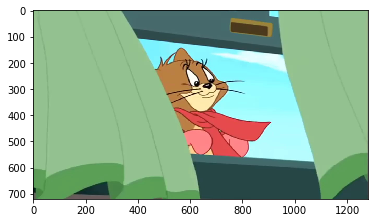

In [4]:
img = plt.imread('./image/frame0.jpg')   # 读取名为 frame0.jpg 的图片
plt.imshow(img)

这是视频的第一帧。我们已经从整个视频的中提取出每个整数秒的帧。由于视频持续时间为4分58秒(298秒) ，我们现在总共有298张图片。

我们的目标是确定哪个图像有汤姆，哪个图像有杰瑞。
如果我们提取的图像与常用的 Imagenet 数据集中的图像相似，这个挑战就会十分简单；我们可以简单地使用预先训练的 Imagenet 数据模型，获得了高精度！但那又有什么意思呢？

我们有的是卡通图片，所以很难找到任何预先训练的模型，来找到汤姆和杰里。

### 步骤2: 标记一些图像作为训练数据

那么我们该如何处理这个问题呢？一个可能的解决方案是手动给一些图像标签并对其进行模型训练。一旦模型学习了这些模式，我们就可以用它来预测其他的图像。

当然可能会有一些帧，汤姆和杰瑞都未出镜。因此，我们将它视为一个多类分类问题。 我定义的类是:

0 –  杰瑞 和 汤姆 都为出镜

1 – 杰瑞

2 – 汤姆

别担心，我已经给所有的图片贴上了标签(https://drive.google.com/file/d/1NbU8Sdj_YNF5Dl_zbdeBcnqEyU3Xw9TU/view) 。
该文件包含每个映像名称及其对应的类(0或1或2)。

In [5]:
data = pd.read_csv('mapping.csv')     # 读取分类文件
data.head()     

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


文件包含两列:

Image_ID(图片编号): 包含所有图像的名称

Class(类别): 包含每个图像的对应类

我们的下一步是根据图片编号制作训练集。

In [6]:
X = [ ]     
for img_name in data.Image_ID:
    img = plt.imread('./image/' + img_name)
    X.append(img)  # 将每个图片的矩阵形式存入
X = np.array(X) 

我们现在已经有了这些图像。 记住，我们需要两样东西来训练我们的模型: 训练集图片，以及对应的类

由于有三个类，我们将使用 keras.utils 的 to_categorical 函数来进行热编码。

In [7]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # 对类进行 独热编码

我们将使用 VGG16 预训模型，该模型采用形状为(224 x 224 x3)的输入图像。由于我们的图像尺寸不同，我们需要调整所有的图像。我们将使用 skimage.transform 的调整函数来实现这一点。

In [8]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # 调整大小为224*224*3
    image.append(a)
X = np.array(image)

/Users/yuchenshen/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


所有的图像都被调整为224 x 224 x 3。但在向模型传递任何输入之前，我们必须根据模型的要求预先处理。我们使用 keras.applications.vgg16的预处理函数来执行这个步骤。

In [9]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # 预处理输入数据，使其符合与训练模型的输入格式

我们还需要一个验证集来检查模型的性能。 我们将利用 sklearn.model_selection 函数，将图像随机划分为训练和验证集。

In [10]:
from sklearn.model_selection import train_test_split # 划分为训练和验证集。
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    

### 第三步: 建立模型

下一步是构建我们的模型。如前所述，我们将使用 VGG16 预训练模型来完成这个任务。让我们首先导入所需的库来构建模型:

In [11]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

我们现在加载 VGG16 预训练模型，并将其存储为基本模型:

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
# include_top=False 将最上层移除来训练我们自己的图片

我们将使用这个模型对训练集和测试集进行预测，得到特征，然后使用这些特性重新训练模型。

In [13]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

训练集和测试集的形状为(208,7,7,512)和(90,7,7,512)。 为了把它传递给我们的神经网络，我们必须把它调整为1维。

In [14]:
X_train = X_train.reshape(208, 7*7*512)      # 调整为1维
X_valid = X_valid.reshape(90, 7*7*512)

现在我们对图像进行进一步预处理，使它们以零为中心，这有助于模型更快地收敛。

In [15]:
train = X_train/X_train.max()      # 使数据中心化
X_valid = X_valid/X_train.max()

最后，我们将建立模型。 这一步可分为三个步骤: 建立模型；
编译模型；
训练模型。

In [16]:
# i. 建立模型
model = Sequential()
model.add(InputLayer((7*7*512,)))    # 输入层
model.add(Dense(units=1024, activation='sigmoid'))   # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=512, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=256, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(3, activation='sigmoid'))            # output layer

用 summary() 函数查看模型的摘要:

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total para

我们的模型中，包含3个隐藏层，和一个有3个神经元的输出层(因为需要预测3个类)。现在我们将编译这个模型:

In [18]:
# ii. 编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight('balanced',np.unique(data.Class), data.Class)  
# 平衡类数量差别

在最后一步，我们将训练模型，并同时检查它的性能，即验证:

In [20]:
# iii. 训练
from keras.callbacks import ModelCheckpoint 
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]      # 模型通过比较验证集准确度 确定检查点 
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid), class_weight=class_weights, callbacks=callbacks_list)

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 4s 17ms/step - loss: 1.1063 - acc: 0.3269 - val_loss: 1.0756 - val_acc: 0.3889

Epoch 00001: val_loss improved from inf to 1.07559, saving model to weights.best.hdf5
Epoch 2/100
208/208 [==============================] - 2s 12ms/step - loss: 1.0745 - acc: 0.3846 - val_loss: 1.0754 - val_acc: 0.3889

Epoch 00002: val_loss improved from 1.07559 to 1.07541, saving model to weights.best.hdf5
Epoch 3/100
208/208 [==============================] - 2s 12ms/step - loss: 1.0782 - acc: 0.3942 - val_loss: 1.0706 - val_acc: 0.3889

Epoch 00003: val_loss improved from 1.07541 to 1.07064, saving model to weights.best.hdf5
Epoch 4/100
208/208 [==============================] - 2s 12ms/step - loss: 1.0653 - acc: 0.4087 - val_loss: 1.0667 - val_acc: 0.3889

Epoch 00004: val_loss improved from 1.07064 to 1.06673, saving model to weights.best.hdf5
Epoch 5/100
208/208 [==============================] - 2s 1

208/208 [==============================] - 2s 11ms/step - loss: 0.0107 - acc: 0.9952 - val_loss: 0.4956 - val_acc: 0.8667

Epoch 00085: val_loss did not improve from 0.33117
Epoch 86/100
208/208 [==============================] - 2s 11ms/step - loss: 0.0085 - acc: 0.9952 - val_loss: 0.4849 - val_acc: 0.8889

Epoch 00086: val_loss did not improve from 0.33117
Epoch 87/100
208/208 [==============================] - 2s 11ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.4910 - val_acc: 0.8778

Epoch 00087: val_loss did not improve from 0.33117
Epoch 88/100
208/208 [==============================] - 2s 12ms/step - loss: 0.0111 - acc: 0.9952 - val_loss: 0.4964 - val_acc: 0.8778

Epoch 00088: val_loss did not improve from 0.33117
Epoch 89/100
208/208 [==============================] - 2s 11ms/step - loss: 0.0081 - acc: 0.9952 - val_loss: 0.5092 - val_acc: 0.8778

Epoch 00089: val_loss did not improve from 0.33117
Epoch 90/100
208/208 [==============================] - 2s 11ms/step - loss: 0

可以看到模型在训练集和验证集上的表现都非常好。在测试集图像上得到了90%左右的准确率。这就是我们如何在视频数据上训练一个模型来得到每帧的类预测。

下面，我们将尝试在一个新的视频中计算 汤姆 和 杰瑞 的出镜时间。

## 三、运用简单方法计算出镜时间

首先，从(https://drive.google.com/file/d/1MQHRosZmeYpK2onCWr_A9p5SI93pEDw0/view) 下载我们将使用的视频。 完成后，继续加载视频并从中提取帧。 我们将采取与上述相同的步骤:

In [21]:
count = 0
videoFile = "Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="./test/test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


从新视频中提取帧之后，我们现在将加载 test.csv 文件，该文件包含每个提取帧的名称。 (https://drive.google.com/file/d/1blewkgF0M6SlJp4x47MVqQEbu4NZmGuF/view)

In [22]:
test = pd.read_csv('testing.csv')

接下来，我们将导入图像进行测试，然后根据前面提到的预训练模型的要求对它们进行调整:

In [23]:
test_y = np_utils.to_categorical(test.Class)

test_image = []
for img_name in test.Image_ID:
    img = plt.imread('./test/' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

/Users/yuchenshen/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


我们需要对这些图像进行调整，就像我们为训练集图片所做的那样。我们将对图像进行预处理，使用 VGG16 预训练模型 base_model.predict()函数从这些图像中提取特征，将这些图像调整为 1-D 形式，并使其以零为中心:

In [24]:
# 预处理图片
test_image = preprocess_input(test_image, mode='tf')

# 使用 VGG16 预训练模型
test_image = base_model.predict(test_image)

# 将数据调整为1-D
test_image = test_image.reshape(186, 7*7*512)

# 使其中心化
test_image = test_image/test_image.max()

由于我们以前已经训练过这个模型，我们将利用这个模型来预测这些图像。

### 步骤4: 对新视频中的图像做出预测

In [25]:
model.load_weights("weights.best.hdf5")

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
scores = model.evaluate(test_image, test_y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

186/186 [==============================] - 0s 1ms/step
acc: 64.52%


In [28]:
predictions = model.predict_classes(test_image)

### 步骤5: 计算汤姆和杰里的出镜时间

回想一下，1代表了 杰瑞 出镜，而 2代表 汤姆 出镜。我们会利用以上的预测来计算这两个传奇人物的出镜时间:

In [29]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 21 seconds
The screen time of TOM is 112 seconds


就是这样！在给定的视频中，我们得到了 汤姆 和 杰瑞 的总出镜时间。

## 四、得到的知识——有用与无用

为了完成这些目标，我尝试和测试了很多，其中有些效果非常好，而有些最终失败了。我将详细阐述我所面临的一些困难，并阐述如何解决这些困难。

首先，我尝试使用 VGG16 预训练模型，但没有移除顶层。结果并不令人满意，可能的原因是由于我们的数据为卡通图像，预训练模型是以实物为基础，因此它无法对这些卡通图像进行分类。为了解决这个问题，我们重新训练了预训练模型，使用了很少的标签图像，结果比以前的结果好。

即使用带标签图像的训练，其准确性也不能令人满意，模型在训练集图像上也得不到很好的结果。因此，我们试图增加隐藏层的数量，增加层数量可以很好地提高训练准确性，但是在训练和测试集的准确性之间并没有同步。对于这样的模型来说，过拟合是十分常见的，它在测试集上的表现并不令人满意。所以我在每一个dense layer之后添加了一个dropout layer，这样模型在训练和测试集上准确性都会得到较好的结果。

我注意到在我们的数据中类的数量并不平衡。汤姆有更多的出镜时间，所以预测是由它主导的，而且大部分帧都被预测为汤姆。为了克服这个问题，让类数量平衡，我使用了 sklearn.utils.class_weight 模块中的compute_class_weight()函数。与数量更多类相比，它给数量较低的类指定了更高的权重。

我还使用了 Model checkpoint 来保存最佳模型，即产生最低验证损失的模型，然后使用该模型进行最终预测。

# 结论

运用这个模型，我们在验证集上得到了90%的准确率，在测试集上得到了64.5%的准确率。

对测试数据准确性低的一个可能原因是训练数据较少。由于模型对像 汤姆 和 杰瑞 这样的卡通形象知识不多，我们必须在训练过程中给它更多的图像。


这些模型可以在各个领域帮助我们: 我们可以计算电影中某个特定演员的出镜时间，计算你最喜欢的超级英雄的出镜时间等等
